In [1]:
import matplotlib.pyplot as plt
import numpy as np



In [2]:
# !pip install pytest


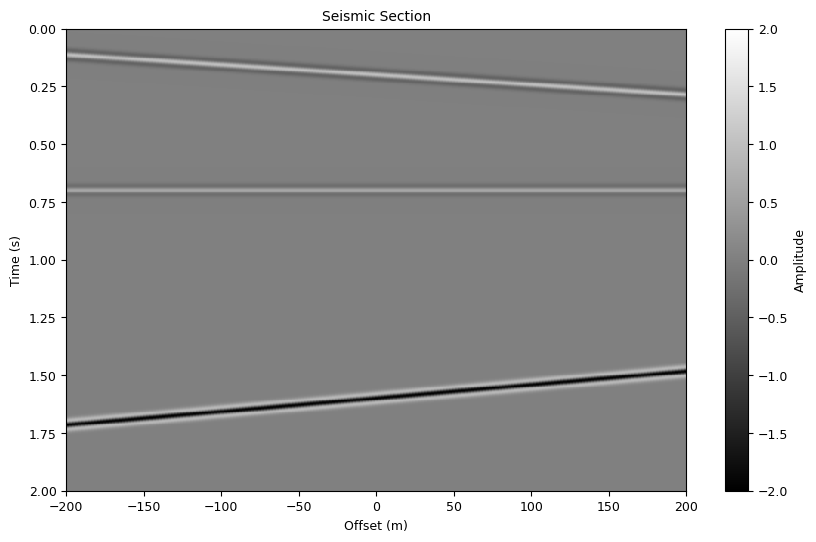

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pylops

# Parameters for the seismic section
par = {
    "ox": -200,
    "dx": 2,
    "nx": 201,
    "oy": -100,
    "dy": 2,
    "ny": 101,
    "ot": 0,
    "dt": 0.004,
    "nt": 501,
    "f0": 20,
    "nfmax": 210,
}

# Create axis
t, t2, x, y = pylops.utils.seismicevents.makeaxis(par)

# Create wavelet
wav = pylops.utils.wavelets.ricker(np.arange(41) * par["dt"], f0=par["f0"])[0]

# Generate seismic data
v = 1500
t0 = [0.2, 0.7, 1.6]
theta = [40, 0, -60]
amp = [1.0, 0.6, -2.0]

mlin, mlinwav = pylops.utils.seismicevents.linear2d(x, t, v, t0, theta, amp, wav)

# Plot with amplitude scale
plt.figure(figsize=(10, 6))
im = plt.imshow(
    mlinwav.T,
    aspect="auto",
    interpolation="nearest",
    vmin=-2,
    vmax=2,
    cmap="gray",
    extent=(x.min(), x.max(), t.max(), t.min())
)

# Add color bar for amplitude scale
cbar = plt.colorbar(im)
cbar.set_label("Amplitude", fontsize=9)
cbar.ax.tick_params(labelsize=9)

# Labels and ticks
plt.xlabel("Offset (m)", fontsize=9)
plt.ylabel("Time (s)", fontsize=9)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.title("Seismic Section", fontsize=10)

plt.show()


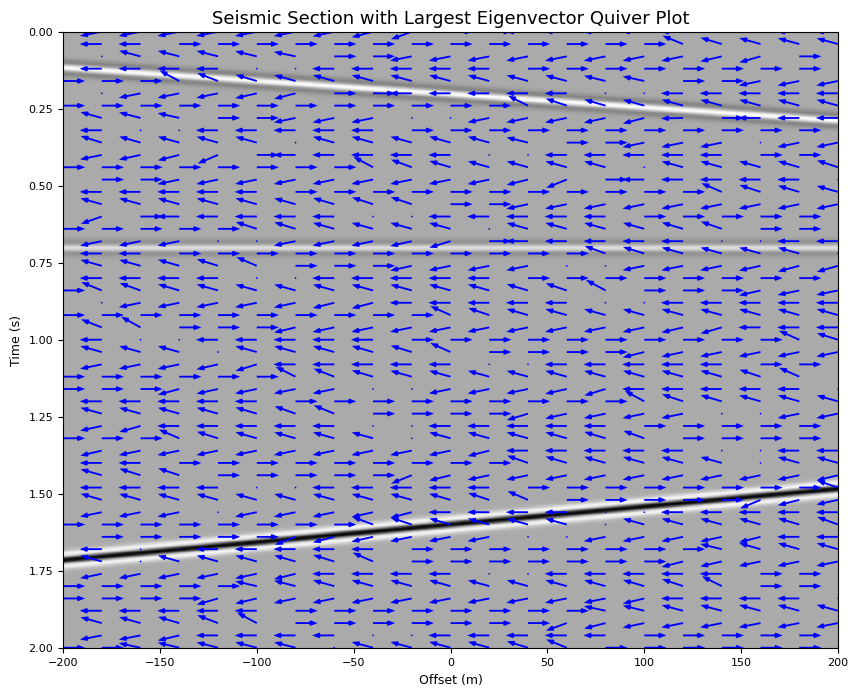

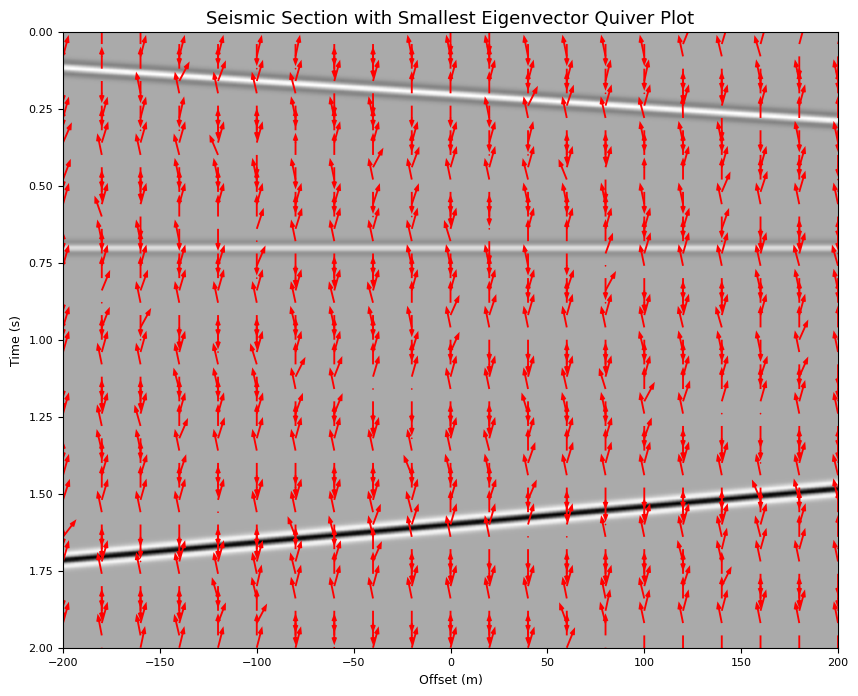

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, gaussian_filter
import pylops

# Parameters for the seismic section
par = {
    "ox": -200,
    "dx": 2,
    "nx": 201,
    "oy": -100,
    "dy": 2,
    "ny": 101,
    "ot": 0,
    "dt": 0.004,
    "nt": 501,
    "f0": 20,
    "nfmax": 210,
}

# Create axis and wavelet
t, t2, x, y = pylops.utils.seismicevents.makeaxis(par)
wav = pylops.utils.wavelets.ricker(np.arange(41) * par["dt"], f0=par["f0"])[0]

# Generate seismic data
v = 1500
t0 = [0.2, 0.7, 1.6]
theta = [40, 0, -60]
amp = [1.0, 0.6, -2.0]
mlin, mlinwav = pylops.utils.seismicevents.linear2d(x, t, v, t0, theta, amp, wav)

##----------------------------------------------QUIVER-------------------------------------------------------------------------##

# Define Gaussian derivative kernels
def gaussian_derivative_kernels(sigma, size=3):
    """Generate Gaussian derivative kernels for x and y directions."""
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    
    # Gaussian kernel derivatives
    G_x = -xx * np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    G_x /= 2 * np.pi * sigma**4
    G_y = -yy * np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    G_y /= 2 * np.pi * sigma**4
    
    return G_x, G_y

# -----------------------Normalize seismic data(0,1)--------------------------------------------#
data_normalized = (mlinwav - np.min(mlinwav)) / (np.max(mlinwav) - np.min(mlinwav))

# Set an amplitude threshold for masking
amplitude_threshold = .63  # Non-zero threshold for low-amplitude filtering
mask = np.abs(data_normalized) >= amplitude_threshold

# Generate Gaussian derivative kernels
sigma_gradient = 1
G_x, G_y = gaussian_derivative_kernels(sigma_gradient)

# Compute gradients using convolution
grad_x = convolve(data_normalized, G_x, mode='reflect')  # Gradient in x (trace) direction
grad_y = convolve(data_normalized, G_y, mode='reflect')  # Gradient in y (time) direction

# Compute the structure tensor components
J_11 = grad_x ** 2
J_22 = grad_y ** 2
J_12 = grad_x * grad_y

# Smooth the components using Gaussian filters
sigma_smoothing = 8
J_11_smoothed = gaussian_filter(J_11, sigma=sigma_smoothing)
J_22_smoothed = gaussian_filter(J_22, sigma=sigma_smoothing)
J_12_smoothed = gaussian_filter(J_12, sigma=sigma_smoothing)

# Perform eigen-decomposition at each point
eigenvectors_u = np.zeros((mlinwav.shape[0], mlinwav.shape[1], 2))  # Largest eigenvector
eigenvectors_v = np.zeros((mlinwav.shape[0], mlinwav.shape[1], 2))  # Smallest eigenvector

for i in range(mlinwav.shape[0]):
    for j in range(mlinwav.shape[1]):
        # Construct the structure tensor
        T = np.array([[J_11_smoothed[i, j], J_12_smoothed[i, j]],
                      [J_12_smoothed[i, j], J_22_smoothed[i, j]]])

        # Compute eigenvalues and eigenvectors
        eigvals, eigvecs = np.linalg.eigh(T)

        # Properly associate eigenvectors
        if eigvals[0] < eigvals[1]:  # Smallest eigenvalue first
            eigenvectors_v[i, j] = eigvecs[:, 0]  # Smallest eigenvector
            eigenvectors_u[i, j] = eigvecs[:, 1]  # Largest eigenvector
        else:
            eigenvectors_v[i, j] = eigvecs[:, 1]
            eigenvectors_u[i, j] = eigvecs[:, 0]

# Create a grid for quiver plot
X, Y = np.meshgrid(x, t)  # Use the generated axes

# Subsample for visualization and apply the mask
step = 10
sub_X = X[::step, ::step]
sub_Y = Y[::step, ::step]
sub_mask = mask[::step, ::step]

sub_eigenvectors_u = eigenvectors_u[::step, ::step]
sub_eigenvectors_v = eigenvectors_v[::step, ::step]

dx_u = sub_eigenvectors_u[:, :, 0] * sub_mask
dy_u = -sub_eigenvectors_u[:, :, 1] * sub_mask

dx_v = sub_eigenvectors_v[:, :, 0] * sub_mask
dy_v = -sub_eigenvectors_v[:, :, 1] * sub_mask

# Plot seismic section with largest eigenvector quiver plot
plt.figure(figsize=(10, 8))
plt.imshow(mlinwav.T, cmap="gray", aspect="auto", extent=[x.min(), x.max(), t.max(), t.min()], alpha=1.0)
plt.quiver(sub_X, sub_Y, dx_u, dy_u, color="blue", scale=35, headwidth=3, headlength=4)
plt.title("Seismic Section with Largest Eigenvector Quiver Plot", fontsize=13)
plt.xlabel("Offset (m)", fontsize=9)
plt.ylabel("Time (s)", fontsize=9)
plt.tick_params(axis="both", which="major", labelsize=8)
plt.show()

# Plot seismic section with smallest eigenvector quiver plot
plt.figure(figsize=(10, 8))
plt.imshow(mlinwav.T, cmap="gray", aspect="auto", extent=[x.min(), x.max(), t.max(), t.min()], alpha=1.0)
plt.quiver(sub_X, sub_Y, dx_v, dy_v, color="red", scale=35, headwidth=3, headlength=4)
plt.title("Seismic Section with Smallest Eigenvector Quiver Plot", fontsize=13)
plt.xlabel("Offset (m)", fontsize=9)
plt.ylabel("Time (s)", fontsize=9)
plt.tick_params(axis="both", which="major", labelsize=8)
plt.show()


In [5]:
###------------------QUIVER with Actual Amplitude(not normalized)------------------------------------------------------##

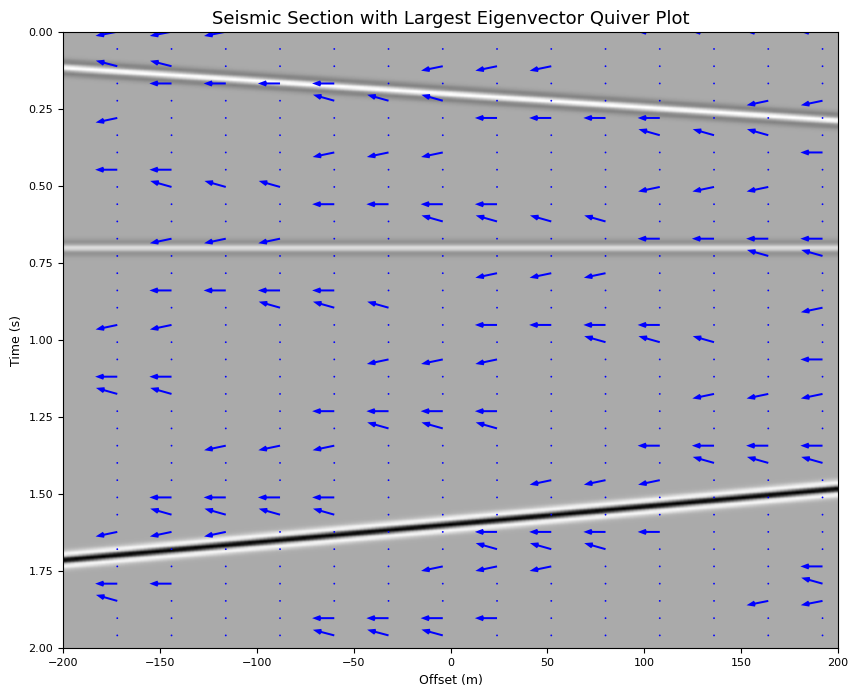

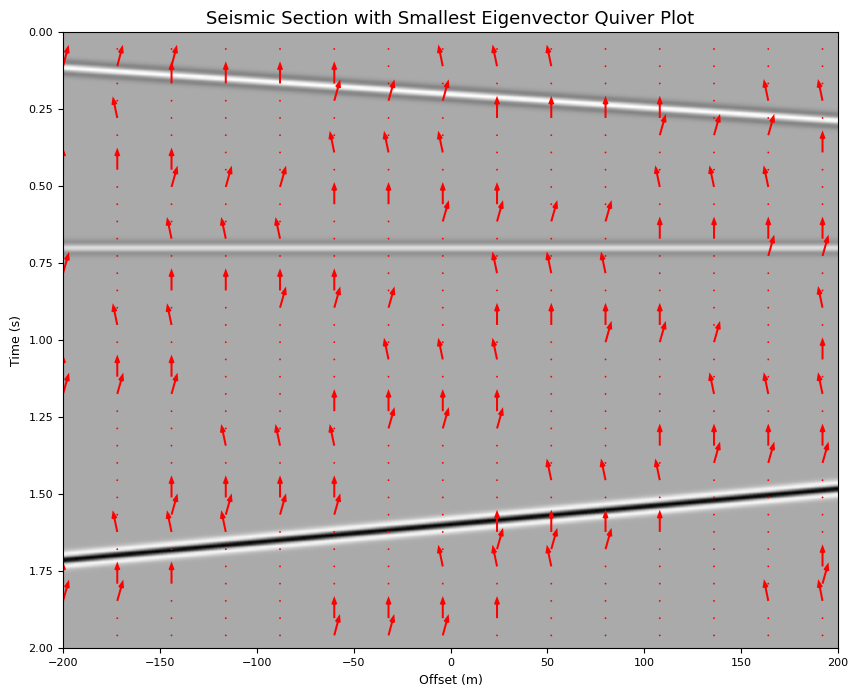

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, gaussian_filter
import pylops

# Parameters for the seismic section
par = {
    "ox": -200,
    "dx": 2,
    "nx": 201,
    "oy": -100,
    "dy": 2,
    "ny": 101,
    "ot": 0,
    "dt": 0.004,
    "nt": 501,
    "f0": 20,
    "nfmax": 210,
}

# Create axis and wavelet
t, t2, x, y = pylops.utils.seismicevents.makeaxis(par)
wav = pylops.utils.wavelets.ricker(np.arange(41) * par["dt"], f0=par["f0"])[0]

# Generate seismic data
v = 1500
t0 = [0.2, 0.7, 1.6]
theta = [40, 0, -60]
amp = [1.0, 0.6, -2.0]
mlin, mlinwav = pylops.utils.seismicevents.linear2d(x, t, v, t0, theta, amp, wav)

# Define Gaussian derivative kernels
def gaussian_derivative_kernels(sigma, size=5):
    """Generate Gaussian derivative kernels for x and y directions."""
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    
    # Gaussian kernel derivatives
    G_x = -xx * np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    G_x /= 2 * np.pi * sigma**4
    G_y = -yy * np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    G_y /= 2 * np.pi * sigma**4
    
    return G_x, G_y

# Generate Gaussian derivative kernels
sigma_gradient = 1
G_x, G_y = gaussian_derivative_kernels(sigma_gradient)

# Compute gradients using convolution
grad_x = convolve(mlinwav, G_x, mode='reflect')  # Gradient in x (trace) direction
grad_y = convolve(mlinwav, G_y, mode='reflect')  # Gradient in y (time) direction

# Compute the structure tensor components
J_11 = grad_x ** 2
J_22 = grad_y ** 2
J_12 = grad_x * grad_y

# Smooth the components using Gaussian filters
sigma_smoothing = 8
J_11_smoothed = gaussian_filter(J_11, sigma=sigma_smoothing)
J_22_smoothed = gaussian_filter(J_22, sigma=sigma_smoothing)
J_12_smoothed = gaussian_filter(J_12, sigma=sigma_smoothing)

# Perform eigen-decomposition at each point
eigenvectors_u = np.zeros((mlinwav.shape[0], mlinwav.shape[1], 2))  # Largest eigenvector
eigenvectors_v = np.zeros((mlinwav.shape[0], mlinwav.shape[1], 2))  # Smallest eigenvector

for i in range(mlinwav.shape[0]):
    for j in range(mlinwav.shape[1]):
        # Construct the structure tensor
        T = np.array([[J_11_smoothed[i, j], J_12_smoothed[i, j]],
                      [J_12_smoothed[i, j], J_22_smoothed[i, j]]])

        # Compute eigenvalues and eigenvectors
        eigvals, eigvecs = np.linalg.eigh(T)

        # Properly associate eigenvectors
        if eigvals[0] < eigvals[1]:  # Smallest eigenvalue first
            eigenvectors_v[i, j] = eigvecs[:, 0]  # Smallest eigenvector
            eigenvectors_u[i, j] = eigvecs[:, 1]  # Largest eigenvector
        else:
            eigenvectors_v[i, j] = eigvecs[:, 1]
            eigenvectors_u[i, j] = eigvecs[:, 0]

# Create a grid for quiver plot
X, Y = np.meshgrid(x, t)  # Use the generated axes

# Subsample for visualization
step = 14
sub_X = X[::step, ::step]
sub_Y = Y[::step, ::step]

# Create a stricter mask to exclude zero-amplitude regions
mask = np.abs(mlinwav) > 1e-11
sub_mask = mask[::step, ::step]

# Subsample eigenvectors
sub_eigenvectors_u = eigenvectors_u[::step, ::step]
sub_eigenvectors_v = eigenvectors_v[::step, ::step]

# Apply mask to quiver components
dx_u = sub_eigenvectors_u[:, :, 0] * sub_mask
dy_u = -sub_eigenvectors_u[:, :, 1] * sub_mask

dx_v = sub_eigenvectors_v[:, :, 0] * sub_mask
dy_v = -sub_eigenvectors_v[:, :, 1] * sub_mask

# Plot seismic section with largest eigenvector quiver plot
plt.figure(figsize=(10, 8))
plt.imshow(mlinwav.T, cmap="gray", aspect="auto", extent=[x.min(), x.max(), t.max(), t.min()], alpha=1.0)
plt.quiver(sub_X, sub_Y, dx_u, dy_u, color="blue", scale=35, headwidth=3, headlength=4)
plt.title("Seismic Section with Largest Eigenvector Quiver Plot", fontsize=13)
plt.xlabel("Offset (m)", fontsize=9)
plt.ylabel("Time (s)", fontsize=9)
plt.tick_params(axis="both", which="major", labelsize=8)
plt.show()

# Plot seismic section with smallest eigenvector quiver plot
plt.figure(figsize=(10, 8))
plt.imshow(mlinwav.T, cmap="gray", aspect="auto", extent=[x.min(), x.max(), t.max(), t.min()], alpha=1.0)
plt.quiver(sub_X, sub_Y, dx_v, dy_v, color="red", scale=35, headwidth=3, headlength=4)
plt.title("Seismic Section with Smallest Eigenvector Quiver Plot", fontsize=13)
plt.xlabel("Offset (m)", fontsize=9)
plt.ylabel("Time (s)", fontsize=9)
plt.tick_params(axis="both", which="major", labelsize=8)
plt.show()


In [73]:
 np.max(np.abs(mlinwav))

np.float64(2.0)

In [7]:
np.shape(mlinwav)

(201, 501)

In [8]:
print(np.sum(mlinwav==0))

51593


In [9]:
mlinwav[100:200,100:200]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.90570776e-12, -1.21568705e-13, -6.80774247e-15],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.90570776e-12, -1.21568705e-13, -6.80774247e-15],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.90570776e-12, -1.21568705e-13, -6.80774247e-15],
       ...,
       [-7.05734393e-22, -1.81750196e-23, -4.11620496e-25, ...,
        -1.90570776e-12, -1.21568705e-13, -6.80774247e-15],
       [-8.92434089e-22, -2.30026346e-23, -5.21342378e-25, ...,
        -1.90570776e-12, -1.21568705e-13, -6.80774247e-15],
       [-7.17211271e-21, -2.07774288e-22, -5.29894255e-24, ...,
        -1.90570776e-12, -1.21568705e-13, -6.80774247e-15]])

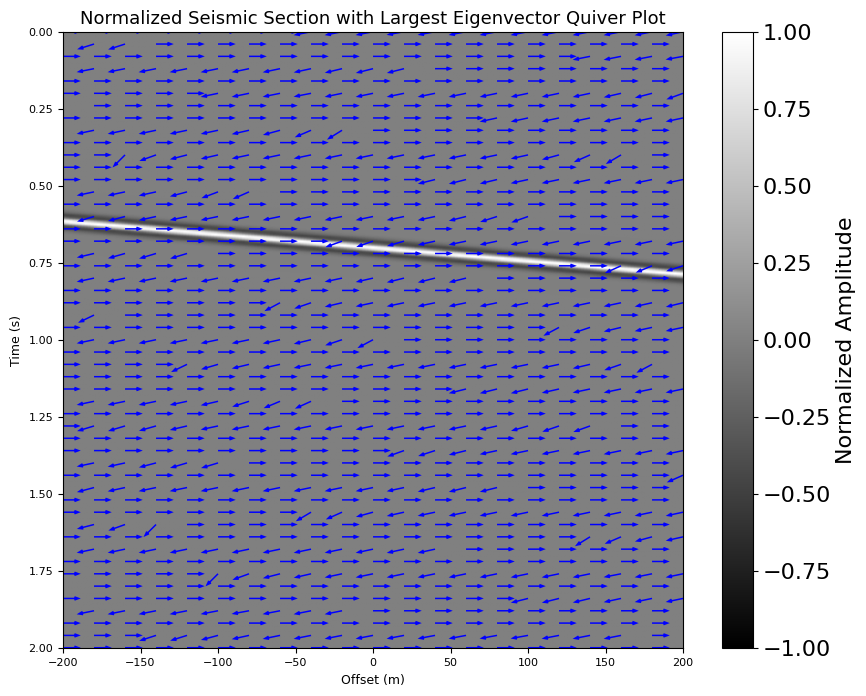

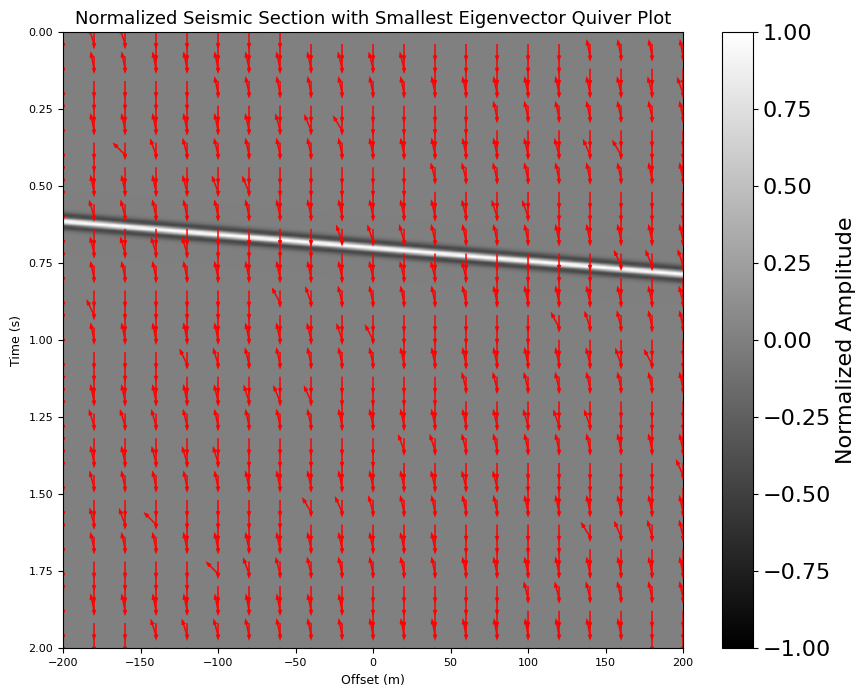

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, gaussian_filter
import pylops

# Parameters for the seismic section
par = {
    "ox": -200,
    "dx": 2,
    "nx": 201,
    "oy": -100,
    "dy": 2,
    "ny": 101,
    "ot": 0,
    "dt": 0.004,
    "nt": 501,
    "f0": 20,
    "nfmax": 210,
}

# Create axis and wavelet
t, t2, x, y = pylops.utils.seismicevents.makeaxis(par)
wav = pylops.utils.wavelets.ricker(np.arange(41) * par["dt"], f0=par["f0"])[0]

# Generate seismic data with only one event
v = 1500
t0 = [0.7]  # Time of the single event
theta = [40]  # Angle of the single event
amp = [1.0]  # Amplitude of the single event
mlin, mlinwav = pylops.utils.seismicevents.linear2d(x, t, v, t0, theta, amp, wav)

# Normalize the seismic data
mlinwav_normalized = mlinwav / np.max(np.abs(mlinwav))

# Set an amplitude threshold for masking
amplitude_threshold =0 # Adjust threshold as needed
mask = np.abs(mlinwav_normalized) >= amplitude_threshold

# Define Gaussian derivative kernels
def gaussian_derivative_kernels(sigma, size=5):
    """Generate Gaussian derivative kernels for x and y directions."""
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    
    # Gaussian kernel derivatives
    G_x = -xx * np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    G_x /= 2 * np.pi * sigma**4
    G_y = -yy * np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    G_y /= 2 * np.pi * sigma**4
    
    return G_x, G_y

# Generate Gaussian derivative kernels
sigma_gradient = 1
G_x, G_y = gaussian_derivative_kernels(sigma_gradient)

# Compute gradients using convolution
grad_x = convolve(mlinwav_normalized, G_x, mode='reflect')  # Gradient in x (trace) direction
grad_y = convolve(mlinwav_normalized, G_y, mode='reflect')  # Gradient in y (time) direction

# Compute the structure tensor components
J_11 = grad_x ** 2
J_22 = grad_y ** 2
J_12 = grad_x * grad_y

# Smooth the components using Gaussian filters
sigma_smoothing = 8
J_11_smoothed = gaussian_filter(J_11, sigma=sigma_smoothing)
J_22_smoothed = gaussian_filter(J_22, sigma=sigma_smoothing)
J_12_smoothed = gaussian_filter(J_12, sigma=sigma_smoothing)

# Perform eigen-decomposition at each point
eigenvectors_u = np.zeros((mlinwav.shape[0], mlinwav.shape[1], 2))  # Largest eigenvector
eigenvectors_v = np.zeros((mlinwav.shape[0], mlinwav.shape[1], 2))  # Smallest eigenvector

for i in range(mlinwav.shape[0]):
    for j in range(mlinwav.shape[1]):
        # Construct the structure tensor
        T = np.array([[J_11_smoothed[i, j], J_12_smoothed[i, j]],
                      [J_12_smoothed[i, j], J_22_smoothed[i, j]]])

        # Compute eigenvalues and eigenvectors
        eigvals, eigvecs = np.linalg.eigh(T)

        # Properly associate eigenvectors
        if eigvals[0] < eigvals[1]:  # Smallest eigenvalue first
            eigenvectors_v[i, j] = eigvecs[:, 0]  # Smallest eigenvector
            eigenvectors_u[i, j] = eigvecs[:, 1]  # Largest eigenvector
        else:
            eigenvectors_v[i, j] = eigvecs[:, 1]
            eigenvectors_u[i, j] = eigvecs[:, 0]

# Create a grid for quiver plot
X, Y = np.meshgrid(x, t)  # Use the generated axes

# Subsample for visualization and apply the mask
step = 10
sub_X = X[::step, ::step]
sub_Y = Y[::step, ::step]
sub_mask = mask[::step, ::step]

sub_eigenvectors_u = eigenvectors_u[::step, ::step]
sub_eigenvectors_v = eigenvectors_v[::step, ::step]

dx_u = sub_eigenvectors_u[:, :, 0] * sub_mask
dy_u = -sub_eigenvectors_u[:, :, 1] * sub_mask

dx_v = sub_eigenvectors_v[:, :, 0] * sub_mask
dy_v = -sub_eigenvectors_v[:, :, 1] * sub_mask

# Plot normalized seismic section with largest eigenvector quiver plot
plt.figure(figsize=(10, 8))
plt.imshow(mlinwav_normalized.T, cmap="gray", aspect="auto", extent=[x.min(), x.max(), t.max(), t.min()], vmin=-1, vmax=1, alpha=1.0)
plt.colorbar(label="Normalized Amplitude")
plt.quiver(sub_X, sub_Y, dx_u, dy_u, color="blue", scale=35, headwidth=3, headlength=4)
plt.title("Normalized Seismic Section with Largest Eigenvector Quiver Plot", fontsize=13)
plt.xlabel("Offset (m)", fontsize=9)
plt.ylabel("Time (s)", fontsize=9)
plt.tick_params(axis="both", which="major", labelsize=8)
plt.show()

# Plot normalized seismic section with smallest eigenvector quiver plot
plt.figure(figsize=(10, 8))
plt.imshow(mlinwav_normalized.T, cmap="gray", aspect="auto", extent=[x.min(), x.max(), t.max(), t.min()], vmin=-1, vmax=1, alpha=1.0)
plt.colorbar(label="Normalized Amplitude")
plt.quiver(sub_X, sub_Y, dx_v, dy_v, color="red", scale=35, headwidth=3, headlength=4)
plt.title("Normalized Seismic Section with Smallest Eigenvector Quiver Plot", fontsize=13)
plt.xlabel("Offset (m)", fontsize=9)
plt.ylabel("Time (s)", fontsize=9)
plt.tick_params(axis="both", which="major", labelsize=8)
plt.show()


In [106]:
# mlinwav_normalized[150:200,150:200]
mlinwav[150:200,150:200]

array([[-1.12853032e-32, -8.35042714e-31, -5.43874172e-29, ...,
        -5.43680471e-03, -1.50967867e-03, -3.64096946e-04],
       [-3.19707416e-33, -2.39893233e-31, -1.58691742e-29, ...,
        -6.49111874e-03, -1.82192946e-03, -4.43507776e-04],
       [-3.92157715e-34, -3.28579968e-32, -2.42240844e-30, ...,
        -8.85461739e-03, -2.62476842e-03, -6.76852292e-04],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         7.25789993e-01,  2.84232137e-01, -1.41275875e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         8.19199892e-01,  3.83181153e-01, -7.82500488e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         8.58308233e-01,  4.76649773e-01,  2.03181424e-02]])

In [107]:
 np.max(np.abs(mlinwav))

np.float64(0.9999999999999949)